In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score

import lightgbm as lgb

import json

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import BoxAnnotation
output_notebook()

import warnings
warnings.filterwarnings("ignore")

Loading BokehJS ...

# Read the data

In [2]:
# DEVICE_NAME = 'dev_7B_16'
DEVICE_NAME = 'tyson_data_mar26_DE_19_D2_0C_10_FD_wo_anomaly'

In [3]:
# read labels exported from labelstud.io
# labeled_data = pd.read_json('project-8-at-2021-07-28-22-06-d2735d4b.json')
# labeled_data = pd.read_json('project-8-at-2021-08-05-22-15-e3b61e12.json')
labeled_data = pd.read_json('project-9-at-2021-08-09-04-44-a201c463.json')

In [4]:
labeled_data

id                                        annotations predictions  \
0  19  [{'id': 7, 'completed_by': {'id': 1, 'email': ...          []   

                                         file_upload  \
0  tyson_data_mar26_DE_19_D2_0C_10_FD_wo_anomaly_...   

                                                data meta  \
0  {'csv_url': '/data/upload/tyson_data_mar26_DE_...   {}   

                        created_at                       updated_at  project  
0 2021-08-06 17:12:43.851288+00:00 2021-08-06 17:12:43.851329+00:00        9

In [5]:
# Select device and convert labels to DataFrane dormat
device_labels_data = pd.DataFrame(labeled_data[labeled_data['file_upload'].str.contains(DEVICE_NAME)]['annotations'].values[0][0]['result'])

labels_df = pd.DataFrame(device_labels_data.value.apply(lambda x: x['start'])).rename(columns={'value':"start"})
labels_df['end'] = pd.DataFrame(device_labels_data.value.apply(lambda x: x['end']))
labels_df['timeserieslabels'] = pd.DataFrame(device_labels_data.value.apply(lambda x: x['timeserieslabels']))

In [6]:
labels_df

start    end timeserieslabels
0     2421   2484         [Cycle1]
1      126    218         [Cycle1]
2      245    311         [Cycle1]
3      343    425         [Cycle1]
4      501    593         [Cycle1]
..     ...    ...              ...
240  24341  24430         [Cycle1]
241  24439  24505         [Cycle1]
242  24516  24556         [Cycle2]
243  24576  24662         [Cycle1]
244  24706  24783         [Cycle1]

[245 rows x 3 columns]

In [7]:
# Read real sensor data
real_df = pd.read_csv(f'{DEVICE_NAME}_to_label.csv')
# Assign zero class to all rows
real_df['label'] = 0

In [8]:
# Take only labeled data (last end index in labeles it is end of labeled data)
real_df = real_df.head(labels_df['end'].tail(1).values[0])

In [9]:
real_df

yaw_anomaly_cleaned  pitch_anomaly_cleaned  roll_anomaly_cleaned  \
0                    95.97                   8.39                -60.35   
1                    94.09                   6.56                -60.89   
2                    92.41                  -1.34                -60.70   
3                    91.42                  -4.92                -60.82   
4                    90.87                   1.01                -59.93   
...                    ...                    ...                   ...   
24778                94.07                  24.29                -69.86   
24779                91.63                  20.47                -73.41   
24780                83.59                  20.35                -63.66   
24781                84.92                  24.57                -52.12   
24782                84.41                  22.38                -58.55   

       a0_anomaly_cleaned  g0x_anomaly_cleaned  g0y_anomaly_cleaned   time  \
0                   10.69                 4.74                 8.03      0   
1                   11.51                 3.96               -14.37      1   
2                   12.23                 5.92                26.25      2   
3                   10.10                 4.31                 2.96      3   
4                   10.31                45.28                75.07      4   
...                   ...                  ...                  ...    ...   
24778                9.81                51.56               -79.74  24778   
24779                9.82                16.76               -44.84  24779   
24780               11.34                 8.09               197.87  24780   
24781               12.74               -11.35               -15.39  24781   
24782                9.45                -4.24                -0.82  24782   

       label  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
24778      0  
24779      0  
24780      0  
24781      0  
24782      0  

[24783 rows x 8 columns]

# Label data

In [10]:
# Label real data
# type_cls: our target could be start or end of the cycle
# margin: because of we have only 1 point od end, it is very accurate point,
# so we need to add margin to left and right side for expand our data 

type_cls = 'end'
margin = 13

for ind, row in labels_df.iterrows():
    real_df.loc[(real_df.time >= row[type_cls] - margin) & (real_df.time <= row[type_cls] + margin), 'label'] = row['timeserieslabels'][0]
    
real_df.label = real_df.label.replace({'Cycle1':1, 'Cycle2':2}).astype(int)

In [11]:
real_df.label.value_counts()

0    18182
1     5008
2     1593
Name: label, dtype: int64

In [12]:
# as we have time as indexes from 1 to ene with step 1, we need to comeback to dates
mapping = pd.read_csv(DEVICE_NAME + '_mapping.csv', usecols=['time', 'Date-Time'], parse_dates=['Date-Time'])

In [13]:
mapping

Date-Time    time
0      2021-05-25 00:00:00.045       0
1      2021-05-25 00:00:00.119       1
2      2021-05-25 00:00:00.236       2
3      2021-05-25 00:00:00.302       3
4      2021-05-25 00:00:00.355       4
...                        ...     ...
740004 2021-05-26 16:21:07.882  740004
740005 2021-05-26 16:21:08.019  740005
740006 2021-05-26 16:21:08.038  740006
740007 2021-05-26 16:21:08.098  740007
740008 2021-05-26 16:21:08.141  740008

[740009 rows x 2 columns]

In [14]:
real_df = pd.merge(real_df, mapping, on=['time']).drop(columns=["time"])
real_df['Date-Time'] = real_df['Date-Time'].dt.tz_localize(None)
real_df = real_df.sort_values('Date-Time')

In [15]:
real_df

yaw_anomaly_cleaned  pitch_anomaly_cleaned  roll_anomaly_cleaned  \
0                    95.97                   8.39                -60.35   
1                    94.09                   6.56                -60.89   
2                    92.41                  -1.34                -60.70   
3                    91.42                  -4.92                -60.82   
4                    90.87                   1.01                -59.93   
...                    ...                    ...                   ...   
24778                94.07                  24.29                -69.86   
24779                91.63                  20.47                -73.41   
24780                83.59                  20.35                -63.66   
24781                84.92                  24.57                -52.12   
24782                84.41                  22.38                -58.55   

       a0_anomaly_cleaned  g0x_anomaly_cleaned  g0y_anomaly_cleaned  label  \
0                   10.69                 4.74                 8.03      0   
1                   11.51                 3.96               -14.37      0   
2                   12.23                 5.92                26.25      0   
3                   10.10                 4.31                 2.96      0   
4                   10.31                45.28                75.07      0   
...                   ...                  ...                  ...    ...   
24778                9.81                51.56               -79.74      1   
24779                9.82                16.76               -44.84      1   
24780               11.34                 8.09               197.87      1   
24781               12.74               -11.35               -15.39      1   
24782                9.45                -4.24                -0.82      1   

                    Date-Time  
0     2021-05-25 00:00:00.045  
1     2021-05-25 00:00:00.119  
2     2021-05-25 00:00:00.236  
3     2021-05-25 00:00:00.302  
4     2021-05-25 00:00:00.355  
...                       ...  
24778 2021-05-25 00:47:15.107  
24779 2021-05-25 00:47:15.108  
24780 2021-05-25 00:47:15.203  
24781 2021-05-25 00:47:15.316  
24782 2021-05-25 00:47:15.381  

[24783 rows x 8 columns]

# Feature engineering

In [16]:
FEATURES = ['yaw_anomaly_cleaned', 'pitch_anomaly_cleaned', 'roll_anomaly_cleaned',
           'a0_anomaly_cleaned',
           'g0x_anomaly_cleaned', 'g0y_anomaly_cleaned']

In [17]:
for i in range(1,40):
    real_df[[col + f'_shift_{i}' for col in FEATURES]] = real_df[FEATURES].shift(i)

In [18]:
# Example:
# So at the 3-rd row we have information about 2-nd, 1-st row
real_df[['yaw_anomaly_cleaned', 'yaw_anomaly_cleaned_shift_1', 'yaw_anomaly_cleaned_shift_2', 'yaw_anomaly_cleaned_shift_3']]

yaw_anomaly_cleaned  yaw_anomaly_cleaned_shift_1  \
0                    95.97                          NaN   
1                    94.09                        95.97   
2                    92.41                        94.09   
3                    91.42                        92.41   
4                    90.87                        91.42   
...                    ...                          ...   
24778                94.07                        99.60   
24779                91.63                        94.07   
24780                83.59                        91.63   
24781                84.92                        83.59   
24782                84.41                        84.92   

       yaw_anomaly_cleaned_shift_2  yaw_anomaly_cleaned_shift_3  
0                              NaN                          NaN  
1                              NaN                          NaN  
2                            95.97                          NaN  
3                            94.09                        95.97  
4                            92.41                        94.09  
...                            ...                          ...  
24778                       106.06                       119.34  
24779                        99.60                       106.06  
24780                        94.07                        99.60  
24781                        91.63                        94.07  
24782                        83.59                        91.63  

[24783 rows x 4 columns]

In [19]:
windows = [10, 20, 30, 40]
for window in windows:
    for feature in FEATURES:
        real_df[f'median_{feature}_{window}'] = real_df[f'{feature}'].transform(lambda x: x.rolling(window).median())

In [20]:
real_df = real_df.dropna()

In [21]:
real_df

yaw_anomaly_cleaned  pitch_anomaly_cleaned  roll_anomaly_cleaned  \
39                  108.78                  15.36                 12.58   
40                  119.41                  19.66                 -7.12   
41                  122.30                  28.86                -26.50   
42                  123.13                  28.54                -24.40   
43                  126.86                  29.51                -32.43   
...                    ...                    ...                   ...   
24778                94.07                  24.29                -69.86   
24779                91.63                  20.47                -73.41   
24780                83.59                  20.35                -63.66   
24781                84.92                  24.57                -52.12   
24782                84.41                  22.38                -58.55   

       a0_anomaly_cleaned  g0x_anomaly_cleaned  g0y_anomaly_cleaned  label  \
39                  13.23                20.20               -69.36      0   
40                  12.04                62.38              -256.33      0   
41                  11.68                23.46                15.39      0   
42                   9.39                13.55                54.63      0   
43                  15.09                -1.57              -211.08      0   
...                   ...                  ...                  ...    ...   
24778                9.81                51.56               -79.74      1   
24779                9.82                16.76               -44.84      1   
24780               11.34                 8.09               197.87      1   
24781               12.74               -11.35               -15.39      1   
24782                9.45                -4.24                -0.82      1   

                    Date-Time  yaw_anomaly_cleaned_shift_1  \
39    2021-05-25 00:00:04.994                        99.42   
40    2021-05-25 00:00:05.147                       108.78   
41    2021-05-25 00:00:05.225                       119.41   
42    2021-05-25 00:00:05.291                       122.30   
43    2021-05-25 00:00:05.451                       123.13   
...                       ...                          ...   
24778 2021-05-25 00:47:15.107                        99.60   
24779 2021-05-25 00:47:15.108                        94.07   
24780 2021-05-25 00:47:15.203                        91.63   
24781 2021-05-25 00:47:15.316                        83.59   
24782 2021-05-25 00:47:15.381                        84.92   

       pitch_anomaly_cleaned_shift_1  ...  median_roll_anomaly_cleaned_30  \
39                             16.17  ...                         -28.935   
40                             15.36  ...                         -26.355   
41                             19.66  ...                         -26.115   
42                             28.86  ...                         -25.065   
43                             28.54  ...                         -25.065   
...                              ...  ...                             ...   
24778                          19.87  ...                         -42.825   
24779                          24.29  ...                         -43.175   
24780                          20.47  ...                         -43.175   
24781                          20.35  ...                         -43.175   
24782                          24.57  ...                         -43.175   

       median_a0_anomaly_cleaned_30  median_g0x_anomaly_cleaned_30  \
39                           11.430                        -10.935   
40                           11.685                        -10.935   
41                           11.675                         -8.805   
42                           11.430                         -4.945   
43                           11.675                         -1.540   
...                             ...                            ...   
24778    

# Convert indexes in labels_df to Date-Time
# Need for undestand averege time of one cycle

In [22]:
dict_for_time_cycle_definition = mapping.to_dict()['Date-Time']

labels_df.start = labels_df.start.apply(lambda x: dict_for_time_cycle_definition[x])
labels_df.end = labels_df.end.apply(lambda x: dict_for_time_cycle_definition[x])
labels_df.timeserieslabels = labels_df.timeserieslabels.apply(lambda x: x[0])

labels_df['execution_time'] = labels_df['end'] - labels_df['start']

In [23]:
labels_df

start                     end timeserieslabels  \
0   2021-05-25 00:04:40.298 2021-05-25 00:04:48.028           Cycle1   
1   2021-05-25 00:00:15.748 2021-05-25 00:00:26.009           Cycle1   
2   2021-05-25 00:00:29.352 2021-05-25 00:00:38.026           Cycle1   
3   2021-05-25 00:00:41.285 2021-05-25 00:00:51.763           Cycle1   
4   2021-05-25 00:00:59.926 2021-05-25 00:01:11.011           Cycle1   
..                      ...                     ...              ...   
240 2021-05-25 00:46:25.887 2021-05-25 00:46:35.520           Cycle1   
241 2021-05-25 00:46:36.435 2021-05-25 00:46:44.175           Cycle1   
242 2021-05-25 00:46:45.269 2021-05-25 00:46:49.542           Cycle2   
243 2021-05-25 00:46:51.692 2021-05-25 00:47:01.547           Cycle1   
244 2021-05-25 00:47:06.584 2021-05-25 00:47:15.613           Cycle1   

            execution_time  
0   0 days 00:00:07.730000  
1   0 days 00:00:10.261000  
2   0 days 00:00:08.674000  
3   0 days 00:00:10.478000  
4   0 days 00:00:11.085000  
..                     ...  
240 0 days 00:00:09.633000  
241 0 days 00:00:07.740000  
242 0 days 00:00:04.273000  
243 0 days 00:00:09.855000  
244 0 days 00:00:09.029000  

[245 rows x 4 columns]

In [24]:
q = 0.5
avg_time_cycle_1 = labels_df[labels_df['timeserieslabels'] == 'Cycle1'].execution_time.quantile(q)
avg_time_cycle_2 = labels_df[labels_df['timeserieslabels'] == 'Cycle2'].execution_time.quantile(q)
avg_time_cycle_1, avg_time_cycle_2

(Timedelta('0 days 00:00:09.595500'), Timedelta('0 days 00:00:03.914000'))

# Split to train test sets

In [25]:
train_size = int(real_df.shape[0]*0.7)
train = real_df.head(train_size)
test = real_df.tail(real_df.shape[0]-train_size)

In [26]:
X_train = train.drop(columns=['label', 'Date-Time']).reset_index(drop=True)
X_test = test.drop(columns=['label', 'Date-Time'])

y_train = train['label'].astype(int).reset_index(drop=True)
y_test = test['label'].astype(int)

# Train a model

In [27]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = y_hat.reshape(len(np.unique(y_true)), -1).T.argmax(axis = 1)
    return 'f1', f1_score(y_true, y_hat, average='weighted'), True

In [28]:
# !pip install lightgbm --install-option=--gpu

In [29]:
def bayes_parameter_opt_lgb(X_train_passed, y_train_passed,
                            init_round=10, opt_round=5, random_seed=6):

    tscv = TimeSeriesSplit(n_splits=3, test_size=int(X_train_passed.shape[0]*0.2))
    
    def lgb_eval(learning_rate, num_leaves, min_child_samples):
        
        params = {
                'num_iterations':1000,
                'application':'multiclass',
                'num_class':3,
                'early_stopping_round':10,
#                 'metric':'auc_mu',
                'metric':'custom',
                'device_type':'gpu',
                'gpu_platform_id' : 0,
                'gpu_device_id' : 0
                 }
        
        params["learning_rate"] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['min_child_samples'] = int(min_child_samples)
        params['verbose'] = -1
        params['is_unbalance'] = True
        
        
        
        scores = []
        for train_index, test_index in tscv.split(X_train_passed):
#             print("TRAIN:", train_index, "TEST:", test_index)
            X_train_fold, X_val_fold = X_train_passed.iloc[train_index], X_train_passed.iloc[test_index]
            y_train_fold, y_val_fold = y_train_passed[train_index], y_train_passed[test_index]
            
            train_data = lgb.Dataset(data=X_train_fold, label=y_train_fold,
                            free_raw_data = False)

            test_data = lgb.Dataset(data=X_val_fold, label=y_val_fold,
                                        free_raw_data = False)

            model = lgb.train(params, train_data, valid_sets = [test_data], verbose_eval = None, feval=lgb_f1_score)
            
            scores.append(model.best_score['valid_0']['f1'])
            
        print(scores)
        return np.mean(scores)

    
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.0003, 0.35),
                                            'num_leaves': (3, 255),
                                            'min_child_samples': (3, 255)
                                           }, random_state=42)
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    
    return lgbBO.res
        


In [30]:
opt_params = bayes_parameter_opt_lgb(X_train, y_train, init_round=5, opt_round=3)

|   iter    |  target   | learni... | min_ch... | num_le... |
-------------------------------------------------------------
[0.7772570459224633, 0.8288078042019255, 0.8354314304033508]
|  1        |  0.8138   |  0.1313   |  242.6    |  187.5    |
[0.785325553120774, 0.8282976786237377, 0.835917546956069]
|  2        |  0.8165   |  0.2097   |  42.32    |  42.31    |
[0.6420795890212577, 0.6242650904625158, 0.6436349454928797]
|  3        |  0.6367   |  0.02061  |  221.3    |  154.5    |
[0.7785984338783563, 0.8299771692933202, 0.8367118542658535]
|  4        |  0.8151   |  0.2479   |  8.187    |  247.4    |
[0.777216631660855, 0.8214143097576432, 0.8310265772719247]
|  5        |  0.8099   |  0.2914   |  56.51    |  48.82    |
[0.7768226248963307, 0.8320122501031053, 0.8335463445189822]
|  6        |  0.8141   |  0.07692  |  251.0    |  216.5    |
[0.7859493497512243, 0.831358640849832, 0.8460678731282152]
|  7        |  0.8211   |  0.2847   |  41.18    |  43.67    |
[0.7795679626436068

In [31]:
best_params = sorted(opt_params, key=lambda k: k['target'], reverse=True)[0]['params']

In [32]:
best_params

{'learning_rate': 0.28471931397203865,
 'min_child_samples': 41.175209349633505,
 'num_leaves': 43.67385338371213}

In [33]:
params = {
        'num_iterations':1000,
        'application':'multiclass',
        'num_class':3,
        'early_stopping_round':10,
        'metric':'custom',
         }

params["learning_rate"] = max(min(best_params['learning_rate'], 1), 0)
params["num_leaves"] = int(round(best_params['num_leaves']))
params['min_child_samples'] = int(best_params['min_child_samples'])
params['verbose'] = -1
    
    
train_data = lgb.Dataset(data=X_train, label=y_train,
                            free_raw_data = False)

test_data = lgb.Dataset(data=X_test, label=y_test,
                            free_raw_data = False)

model = lgb.train(params, train_data, valid_sets = [test_data], feval=lgb_f1_score)

[1]	valid_0's f1: 0.722144
Training until validation scores don't improve for 10 rounds
[2]	valid_0's f1: 0.77752
[3]	valid_0's f1: 0.802966
[4]	valid_0's f1: 0.818582
[5]	valid_0's f1: 0.828429
[6]	valid_0's f1: 0.832418
[7]	valid_0's f1: 0.836623
[8]	valid_0's f1: 0.839454
[9]	valid_0's f1: 0.84217
[10]	valid_0's f1: 0.841817
[11]	valid_0's f1: 0.8451
[12]	valid_0's f1: 0.846818
[13]	valid_0's f1: 0.848589
[14]	valid_0's f1: 0.848503
[15]	valid_0's f1: 0.849485
[16]	valid_0's f1: 0.849614
[17]	valid_0's f1: 0.851121
[18]	valid_0's f1: 0.848982
[19]	valid_0's f1: 0.852471
[20]	valid_0's f1: 0.853657
[21]	valid_0's f1: 0.852634
[22]	valid_0's f1: 0.854565
[23]	valid_0's f1: 0.854739
[24]	valid_0's f1: 0.853507
[25]	valid_0's f1: 0.854851
[26]	valid_0's f1: 0.855606
[27]	valid_0's f1: 0.854862
[28]	valid_0's f1: 0.855871
[29]	valid_0's f1: 0.857362
[30]	valid_0's f1: 0.855479
[31]	valid_0's f1: 0.854022
[32]	valid_0's f1: 0.854664
[33]	valid_0's f1: 0.854799
[34]	valid_0's f1: 0.855099


# Metrics

In [34]:
y_pred = model.predict(X_test)

In [35]:
y_pred = np.argmax(y_pred, axis=1)

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [37]:
accuracy_score(y_test, y_pred)

0.8631465517241379

In [38]:
f1_score(y_test, y_pred, average='micro'), f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='weighted')

(0.8631465517241379, 0.8019615570488666, 0.8573623039409756)

In [39]:
precision_score(y_test, y_pred, average='micro'), precision_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='weighted')

(0.8631465517241379, 0.8515475462093848, 0.8593906605036236)

In [40]:
recall_score(y_test, y_pred, average='micro'), recall_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='weighted')

(0.8631465517241379, 0.7656311624703775, 0.8631465517241379)

<AxesSubplot:>

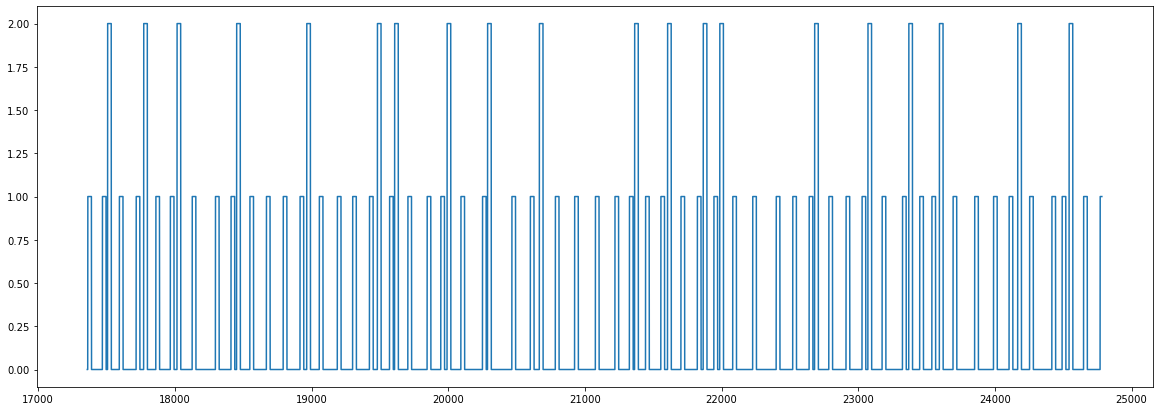

In [41]:
y_test.plot(figsize=(20,7))

<AxesSubplot:>

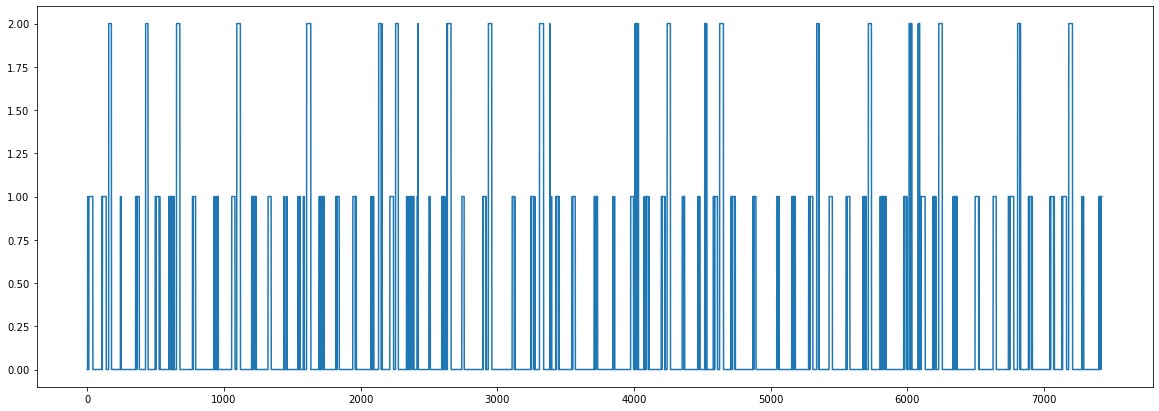

In [42]:
pd.Series(y_pred).plot(figsize=(20,7))

In [43]:
# Now predictions it is sequense of predicted classes
# Example: 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0
# So we combine gaps of 0
# Expected output : 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0

In [44]:
# For cycle 1
max_distance_between = 30
max_distance_current = 0
cycle_starts = []
current_start = []
for i in range(y_pred.shape[0]):
    if y_pred[i] == 1:
        current_start.append(i)
        max_distance_current = 0
    
    if y_pred[i] == 0:
        max_distance_current += 1
        
    
    if len(current_start) != 0 and max_distance_between < max_distance_current:
        cycle_starts.append(current_start)
        current_start = []   

In [45]:
# For cycle 2
max_distance_between = 30
max_distance_current = 0
cycle_starts_2 = []
current_start_2 = []
for i in range(y_pred.shape[0]):
    if y_pred[i] == 2:
        current_start_2.append(i)
        max_distance_current = 0
    
    if y_pred[i] == 0:
        max_distance_current += 1
        
    
    if len(current_start_2) != 0 and max_distance_between < max_distance_current:
        cycle_starts_2.append(current_start_2)
        current_start_2 = []   

In [46]:
start_indexes = [int(np.mean(i)) for i in cycle_starts]
start_indexes_2 = [int(np.mean(i)) for i in cycle_starts_2]

In [47]:
len(start_indexes)

55

In [48]:
len(start_indexes_2)

23

In [49]:
y_test[y_test==1].sum() / (margin*2+1)

55.48148148148148

In [50]:
y_test[y_test==2].sum() / (margin*2+1) / 2

20.0

# Plot predictions

In [51]:
prediction = pd.DataFrame(y_pred)

prediction[0] = 0
prediction.loc[start_indexes, 0] = 1
prediction.loc[start_indexes_2, 0] = 2

In [52]:
prediction[0].value_counts()

0    7346
1      55
2      23
Name: 0, dtype: int64

In [53]:
result = test[FEATURES + ['Date-Time']].copy()
result['predicted'] = prediction[0].values
result['real'] = y_test
result = result.reset_index(drop=True)

<AxesSubplot:xlabel='Date-Time'>

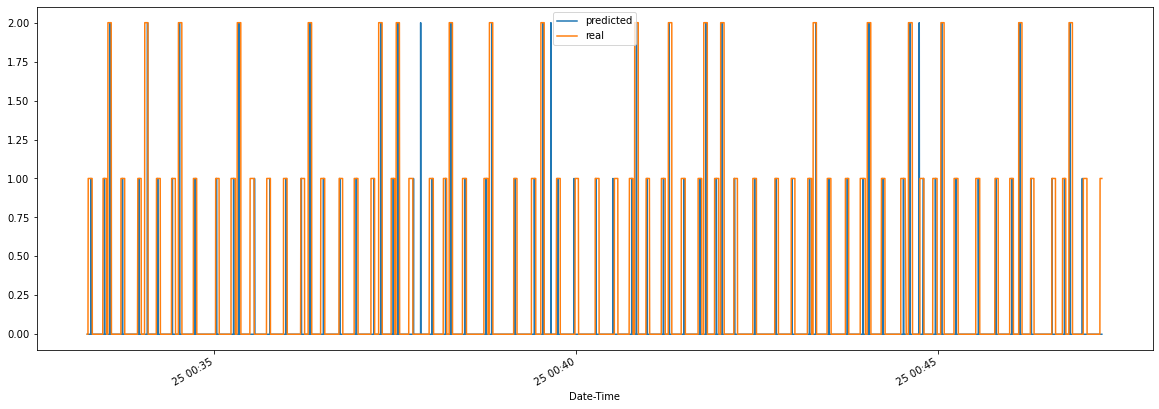

In [54]:
result.set_index('Date-Time')[['predicted', 'real']].plot(figsize=(20,7))

In [55]:
result['predicted'].value_counts()[1] * avg_time_cycle_1

Timedelta('0 days 00:08:47.752500')

In [56]:
result['predicted'].value_counts()[2] * avg_time_cycle_2

Timedelta('0 days 00:01:30.022000')

In [57]:
result

yaw_anomaly_cleaned  pitch_anomaly_cleaned  roll_anomaly_cleaned  \
0                   95.15                  21.85                -33.60   
1                  104.42                  30.40                -39.09   
2                  105.08                  32.63                -35.99   
3                  108.16                  30.31                -36.95   
4                  110.73                  31.21                -40.92   
...                   ...                    ...                   ...   
7419                94.07                  24.29                -69.86   
7420                91.63                  20.47                -73.41   
7421                83.59                  20.35                -63.66   
7422                84.92                  24.57                -52.12   
7423                84.41                  22.38                -58.55   

      a0_anomaly_cleaned  g0x_anomaly_cleaned  g0y_anomaly_cleaned  \
0                  13.46               -40.06              -120.23   
1                   9.70                15.20               -23.72   
2                  11.01                19.56                -6.96   
3                   9.75               -10.38               -43.20   
4                  10.96               -13.51                -2.62   
...                  ...                  ...                  ...   
7419                9.81                51.56               -79.74   
7420                9.82                16.76               -44.84   
7421               11.34                 8.09               197.87   
7422               12.74               -11.35               -15.39   
7423                9.45                -4.24                -0.82   

                   Date-Time  predicted  real  
0    2021-05-25 00:33:14.848          0     0  
1    2021-05-25 00:33:15.275          0     0  
2    2021-05-25 00:33:15.353          0     0  
3    2021-05-25 00:33:15.405          0     0  
4    2021-05-25 00:33:15.564          0     1  
...                      ...        ...   ...  
7419 2021-05-25 00:47:15.107          0     1  
7420 2021-05-25 00:47:15.108          0     1  
7421 2021-05-25 00:47:15.203          0     1  
7422 2021-05-25 00:47:15.316          0     1  
7423 2021-05-25 00:47:15.381          0     1  

[7424 rows x 9 columns]

In [58]:
labels_df

start                     end timeserieslabels  \
0   2021-05-25 00:04:40.298 2021-05-25 00:04:48.028           Cycle1   
1   2021-05-25 00:00:15.748 2021-05-25 00:00:26.009           Cycle1   
2   2021-05-25 00:00:29.352 2021-05-25 00:00:38.026           Cycle1   
3   2021-05-25 00:00:41.285 2021-05-25 00:00:51.763           Cycle1   
4   2021-05-25 00:00:59.926 2021-05-25 00:01:11.011           Cycle1   
..                      ...                     ...              ...   
240 2021-05-25 00:46:25.887 2021-05-25 00:46:35.520           Cycle1   
241 2021-05-25 00:46:36.435 2021-05-25 00:46:44.175           Cycle1   
242 2021-05-25 00:46:45.269 2021-05-25 00:46:49.542           Cycle2   
243 2021-05-25 00:46:51.692 2021-05-25 00:47:01.547           Cycle1   
244 2021-05-25 00:47:06.584 2021-05-25 00:47:15.613           Cycle1   

            execution_time  
0   0 days 00:00:07.730000  
1   0 days 00:00:10.261000  
2   0 days 00:00:08.674000  
3   0 days 00:00:10.478000  
4   0 days 00:00:11.085000  
..                     ...  
240 0 days 00:00:09.633000  
241 0 days 00:00:07.740000  
242 0 days 00:00:04.273000  
243 0 days 00:00:09.855000  
244 0 days 00:00:09.029000  

[245 rows x 4 columns]

In [59]:
f = 'roll_anomaly_cleaned'

data = result.set_index('Date-Time')[[f]]

p = figure(plot_height=450, plot_width=1200, x_axis_type='datetime')
p.line(x=data.index,
       y=data[f].values)


for ind in result[result.predicted == 1]['Date-Time']:
        red_box = BoxAnnotation(left=ind-avg_time_cycle_1, right=ind, fill_color='green', fill_alpha=0.5)
        p.add_layout(red_box)
        
for ind in result[result.predicted == 2]['Date-Time']:
        red_box = BoxAnnotation(left=ind-avg_time_cycle_2, right=ind, fill_color='red', fill_alpha=0.5)
        p.add_layout(red_box)
        
        
for ind, row in labels_df[labels_df.timeserieslabels == 'Cycle1'].iterrows():
        red_box = BoxAnnotation(left=row['start'], right=row['end'], fill_color='yellow', fill_alpha=0.5)
        p.add_layout(red_box)
        
for ind, row in labels_df[labels_df.timeserieslabels == 'Cycle2'].iterrows():
        red_box = BoxAnnotation(left=row['start'], right=row['end'], fill_color='black', fill_alpha=0.5)
        p.add_layout(red_box)


show(p)